In [24]:
import pandas as pd
import json, os, sys
import logging
from datetime import datetime
from matplotlib_inline.backend_inline import set_matplotlib_formats
import matplotlib.pyplot as plt
from localutils.cveutils import extract_cwe_for_cve
from functools import lru_cache as LRU

# set up the current date and time as one string
current_date = datetime.now().strftime('%Y-%m-%d')
current_time = datetime.now().strftime('%H:%M:%S')


#Set up logging
logging.basicConfig(
    level=logging.INFO,
    format="%(asctime)s - %(levelname)s - %(message)s",
    handlers=[
        logging.FileHandler(f"logs/app-{current_date+current_time}.log"),
        logging.StreamHandler()
    ]
)
logger = logging.getLogger(__name__)

In [3]:
# show all lines for dataframe
pd.set_option('display.max_rows', None)
# show original length of columns for dataframe
pd.set_option('display.max_columns', None)

In [4]:
cves_cwes_df = extract_cwe_for_cve("data/download/NVDCVE")

2025-02-16 21:17:42,507 - INFO - Reading file nvdcve-1.1-2004.json
2025-02-16 21:17:42,700 - INFO - Reading file nvdcve-1.1-2005.json
2025-02-16 21:17:43,371 - INFO - Reading file nvdcve-1.1-2006.json
2025-02-16 21:17:44,151 - INFO - Reading file nvdcve-1.1-2007.json
2025-02-16 21:17:44,922 - INFO - Reading file nvdcve-1.1-2008.json
2025-02-16 21:17:45,938 - INFO - Reading file nvdcve-1.1-2009.json
2025-02-16 21:17:46,528 - INFO - Reading file nvdcve-1.1-2010.json
2025-02-16 21:17:47,518 - INFO - Reading file nvdcve-1.1-2011.json
2025-02-16 21:17:48,309 - INFO - Reading file nvdcve-1.1-2012.json
2025-02-16 21:17:48,939 - INFO - Reading file nvdcve-1.1-2013.json
2025-02-16 21:17:50,137 - INFO - Reading file nvdcve-1.1-2014.json
2025-02-16 21:17:51,434 - INFO - Reading file nvdcve-1.1-2015.json
2025-02-16 21:17:52,515 - INFO - Reading file nvdcve-1.1-2016.json
2025-02-16 21:17:54,004 - INFO - Reading file nvdcve-1.1-2017.json
2025-02-16 21:17:56,778 - INFO - Reading file nvdcve-1.1-2018.

Text(0.5, 1.0, 'Top 10 CWEs for CVEs 2004-2025')

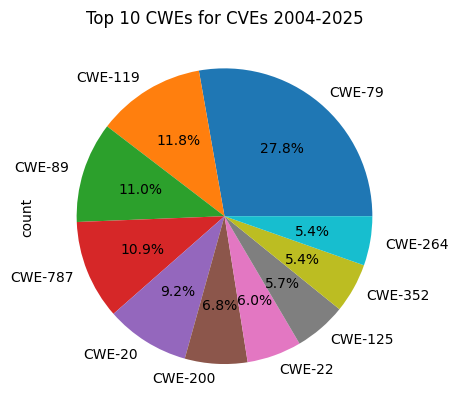

In [7]:
# plot top 10 CWEs without 'not_found' and 'NVD-CWE-noinfo' values
cves_cwes_df['cwe_id'].value_counts().drop(['not_found', 'NVD-CWE-noinfo', 'NVD-CWE-Other']).head(10).plot(kind='pie', autopct='%1.1f%%')
plt.title('Top 10 CWEs for CVEs 2004-2025')

Text(0.5, 1.0, 'Top 10 CWEs for CVEs 2020-2025')

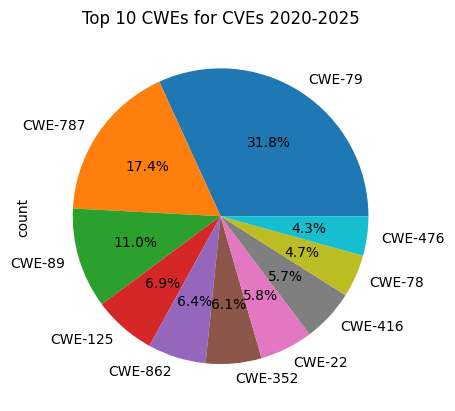

In [8]:
# top 10 CWEs without 'not_found' and 'NVD-CWE-noinfo' values for years 2020-2025
cves_cwes_df[cves_cwes_df['cve_id'].str.contains('202[0-5]')]['cwe_id'].value_counts().drop(['not_found', 'NVD-CWE-noinfo', 'NVD-CWE-Other']).head(10).plot(kind='pie', autopct='%1.1f%%')
plt.title('Top 10 CWEs for CVEs 2020-2025')


In [11]:
list_of_cwes = list(set(cves_cwes_df[~cves_cwes_df['cwe_id'].isin(['not_found', 'NVD-CWE-noinfo', 'NVD-CWE-Other'])]["cwe_id"].to_list()))


In [22]:
list_of_cwes

['CWE-390',
 'CWE-1242',
 'CWE-274',
 'CWE-943',
 'CWE-349',
 'CWE-616',
 'CWE-209',
 'CWE-199',
 'CWE-1281',
 'CWE-178',
 'CWE-74',
 'CWE-23',
 'CWE-1263',
 'CWE-912',
 'CWE-328',
 'CWE-489',
 'CWE-254',
 'CWE-294',
 'CWE-308',
 'CWE-668',
 'CWE-914',
 'CWE-617',
 'CWE-444',
 'CWE-549',
 'CWE-824',
 'CWE-1004',
 'CWE-1104',
 'CWE-644',
 'CWE-1384',
 'CWE-147',
 'CWE-598',
 'CWE-544',
 'CWE-835',
 'CWE-313',
 'CWE-19',
 'CWE-404',
 'CWE-552',
 'CWE-353',
 'CWE-917',
 'CWE-25',
 'CWE-775',
 'CWE-346',
 'CWE-255',
 'CWE-256',
 'CWE-319',
 'CWE-189',
 'CWE-41',
 'CWE-601',
 'CWE-295',
 'CWE-347',
 'CWE-270',
 'CWE-670',
 'CWE-281',
 'CWE-613',
 'CWE-402',
 'CWE-942',
 'CWE-330',
 'CWE-16',
 'CWE-36',
 'CWE-20',
 'CWE-291',
 'CWE-455',
 'CWE-122',
 'CWE-406',
 'CWE-358',
 'CWE-650',
 'CWE-252',
 'CWE-669',
 'CWE-1188',
 'CWE-92',
 'CWE-1385',
 'CWE-233',
 'CWE-548',
 'CWE-470',
 'CWE-334',
 'CWE-73',
 'CWE-693',
 'CWE-1021',
 'CWE-287',
 'CWE-1007',
 'CWE-664',
 'CWE-184',
 'CWE-805',
 'CW

In [25]:
import requests

# add cwe descriptions to cwe_id in cves_cwes_df by matching CWE-ID with the cwes dataframe
# https://cwe-api.mitre.org/api/v1/cwe/weakness/193

def get_cwe_name_and_description(cwe_id):
	try:
		logger.info(f"Getting CWE data for {cwe_id}")
		url = f"https://cwe-api.mitre.org/api/v1/cwe/weakness/{cwe_id.split('-')[1]}"
		response = requests.get(url)
		cwe_data = response.json()
		cwe_name =  cwe_data.get("Weaknesses")[0].get("Name")
		cwe_description = cwe_data.get("Weaknesses")[0].get("Description")
		return {"cwe_id": cwe_id, "cwe_name": cwe_name, "cwe_desc": cwe_description}
	except Exception as e:
		logger.error(f"Error getting CWE data for {cwe_id}, error: {e}")
		return {"cwe_id": cwe_id, "cwe_name": "not_found", "cwe_desc": "not_found"}




cwes_df = pd.DataFrame([get_cwe_name_and_description(cwe_id) for cwe_id in list_of_cwes])

2025-02-17 08:07:14,582 - INFO - Getting CWE data for CWE-390
2025-02-17 08:07:15,025 - INFO - Getting CWE data for CWE-1242
2025-02-17 08:07:15,469 - INFO - Getting CWE data for CWE-274
2025-02-17 08:07:15,907 - INFO - Getting CWE data for CWE-943
2025-02-17 08:07:16,372 - INFO - Getting CWE data for CWE-349
2025-02-17 08:07:16,812 - INFO - Getting CWE data for CWE-616
2025-02-17 08:07:17,252 - INFO - Getting CWE data for CWE-209
2025-02-17 08:07:17,821 - INFO - Getting CWE data for CWE-199
2025-02-17 08:07:18,287 - ERROR - Error getting CWE data for CWE-199, error: 'str' object has no attribute 'get'
2025-02-17 08:07:18,288 - INFO - Getting CWE data for CWE-1281
2025-02-17 08:07:18,750 - INFO - Getting CWE data for CWE-178
2025-02-17 08:07:19,188 - INFO - Getting CWE data for CWE-74
2025-02-17 08:07:19,732 - INFO - Getting CWE data for CWE-23
2025-02-17 08:07:20,271 - INFO - Getting CWE data for CWE-1263
2025-02-17 08:07:20,711 - INFO - Getting CWE data for CWE-912
2025-02-17 08:07:2

In [26]:
cwes_df

,cwe_id,cwe_name,cwe_desc
0,CWE-390,Detection of Error Condition Without Action,"The product detects a specific error, but take..."
1,CWE-1242,Inclusion of Undocumented Features or Chicken ...,The device includes chicken bits or undocument...
2,CWE-274,Improper Handling of Insufficient Privileges,The product does not handle or incorrectly han...
3,CWE-943,Improper Neutralization of Special Elements in...,The product generates a query intended to acce...
4,CWE-349,Acceptance of Extraneous Untrusted Data With T...,"The product, when processing trusted data, acc..."
5,CWE-616,Incomplete Identification of Uploaded File Var...,The PHP application uses an old method for pro...
6,CWE-209,Generation of Error Message Containing Sensiti...,The product generates an error message that in...
7,CWE-199,not_found,not_found
8,CWE-1281,Sequence of Processor Instructions Leads to Un...,Specific combinations of processor instruction...
9,CWE-178,Improper Handling of Case Sensitivity,The product does not properly account for diff...


In [12]:
cves_cwes_df.tail(10)

,cve_id,cwe_id
273123,CVE-2025-26572,CWE-352
273124,CVE-2025-26574,CWE-79
273125,CVE-2025-26577,CWE-352
273126,CVE-2025-26578,CWE-352
273127,CVE-2025-26580,CWE-352
273128,CVE-2025-26582,CWE-352
273129,CVE-2025-26788,not_found
273130,CVE-2025-26789,not_found
273131,CVE-2025-26791,not_found
273132,CVE-2025-26819,not_found


In [30]:
# show me cwe-79 by index number
cwes.loc[79].to_dict()

{'CWE-ID': "Improper Neutralization of Input During Web Page Generation ('Cross-site Scripting')",
 'Name': 'Base',
 'Weakness Abstraction': 'Stable',
 'Status': 'The product does not neutralize or incorrectly neutralizes user-controllable input before it is placed in output that is used as a web page that is served to other users.',
 'Description': "Cross-site scripting (XSS) vulnerabilities occur when: Untrusted data enters a web application, typically from a web request. The web application dynamically generates a web page that contains this untrusted data. During page generation, the application does not prevent the data from containing content that is executable by a web browser, such as JavaScript, HTML tags, HTML attributes, mouse events, Flash, ActiveX, etc. A victim visits the generated web page through a web browser, which contains malicious script that was injected using the untrusted data. Since the script comes from a web page that was sent by the web server, the victim's 